# tseries

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

In [3]:
# Disable caching for performance testing
vbt.defaults.caching = False

In [4]:
index = pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
], freq='D')
columns = ['a', 'b', 'c']
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, np.nan], 
    'b': [np.nan, 4, 3, 2, 1],
    'c': [1, 2, np.nan, 2, 1]}, index=index).astype(np.float32)

print(ts)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  NaN
2018-01-04  4.0  2.0  2.0
2018-01-05  NaN  1.0  1.0


In [5]:
big_ts = pd.DataFrame(np.random.randint(10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [6]:
# Test index frequency
print(ts.vbt.tseries.freq)
print(ts['a'].vbt.tseries.freq)
print(ts.vbt.tseries(freq='2D').freq)
print(ts['a'].vbt.tseries(freq='2D').freq)
print(pd.Series([1, 2, 3]).vbt.tseries.freq)
print(pd.Series([1, 2, 3]).vbt.tseries(freq='3D').freq)
print(pd.Series([1, 2, 3]).vbt.tseries(freq=np.timedelta64(4, 'D')).freq)

1 days 00:00:00
1 days 00:00:00
2 days 00:00:00
2 days 00:00:00
None
3 days 00:00:00
4 days 00:00:00


In [8]:
print(ts['a'].vbt.tseries.split_into_ranges(n=2))
%timeit big_ts.iloc[:, 0].vbt.tseries.split_into_ranges(n=100)

print(ts.vbt.tseries.split_into_ranges(n=2))
%timeit big_ts.vbt.tseries.split_into_ranges(n=100)

print(ts['a'].vbt.tseries.split_into_ranges(range_len=2))
%timeit big_ts.iloc[:, 0].vbt.tseries.split_into_ranges(range_len=100)

print(ts.vbt.tseries.split_into_ranges(range_len=2))
%timeit big_ts.vbt.tseries.split_into_ranges(range_len=100)

range_start 2018-01-01 2018-01-04
range_end   2018-01-02 2018-01-05
0                  1.0        4.0
1                  2.0        NaN
3.59 ms ± 515 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                     a                     b                     c           
range_start 2018-01-01 2018-01-04 2018-01-01 2018-01-04 2018-01-01 2018-01-04
range_end   2018-01-02 2018-01-05 2018-01-02 2018-01-05 2018-01-02 2018-01-05
0                  1.0        4.0        NaN        2.0        1.0        2.0
1                  2.0        NaN        4.0        1.0        2.0        1.0
740 ms ± 5.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
range_start 2018-01-01 2018-01-02 2018-01-03 2018-01-04
range_end   2018-01-02 2018-01-03 2018-01-04 2018-01-05
0                  1.0        2.0        3.0        4.0
1                  2.0        3.0        4.0        NaN
4.15 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                     a                  

In [16]:
print(ts.fillna(-1))
%timeit big_ts.fillna(-1)

print(ts.vbt.tseries.fillna(-1))
%timeit big_ts.vbt.tseries.fillna(-1)

              a    b    c
2018-01-01  1.0 -1.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0 -1.0
2018-01-04  4.0  2.0  2.0
2018-01-05 -1.0  1.0  1.0
6.98 ms ± 551 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  1.0 -1.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0 -1.0
2018-01-04  4.0  2.0  2.0
2018-01-05 -1.0  1.0  1.0
4.04 ms ± 440 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
print(ts.shift(3))
%timeit big_ts.shift(3)

print(ts.vbt.tseries.fshift(3))
%timeit big_ts.vbt.tseries.fshift(3)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  NaN  NaN  NaN
2018-01-04  1.0  NaN  1.0
2018-01-05  2.0  4.0  2.0
2.22 ms ± 63.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  NaN  NaN  NaN
2018-01-04  1.0  NaN  1.0
2018-01-05  2.0  4.0  2.0
2.29 ms ± 58.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
print(ts.diff())
%timeit big_ts.diff()

print(ts.vbt.tseries.diff())
%timeit big_ts.vbt.tseries.diff()

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  1.0 -1.0  NaN
2018-01-04  1.0 -1.0  NaN
2018-01-05  NaN -1.0 -1.0
4.46 ms ± 45.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  1.0 -1.0  NaN
2018-01-04  1.0 -1.0  NaN
2018-01-05  NaN -1.0 -1.0
4.35 ms ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
print(ts.pct_change(fill_method=None))
%timeit big_ts.pct_change(fill_method=None)

print(ts.vbt.tseries.pct_change())
%timeit big_ts.vbt.tseries.pct_change()

                   a         b    c
2018-01-01       NaN       NaN  NaN
2018-01-02  1.000000       NaN  1.0
2018-01-03  0.500000 -0.250000  NaN
2018-01-04  0.333333 -0.333333  NaN
2018-01-05       NaN -0.500000 -0.5
331 ms ± 48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b    c
2018-01-01       NaN       NaN  NaN
2018-01-02  1.000000       NaN  1.0
2018-01-03  0.500000 -0.250000  NaN
2018-01-04  0.333333 -0.333333  NaN
2018-01-05       NaN -0.500000 -0.5
5.61 ms ± 546 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
print(ts.ffill())
%timeit big_ts.ffill()

print(ts.vbt.tseries.ffill())
%timeit big_ts.vbt.tseries.ffill()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  2.0
2018-01-04  4.0  2.0  2.0
2018-01-05  4.0  1.0  1.0
6.52 ms ± 701 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  2.0
2018-01-04  4.0  2.0  2.0
2018-01-05  4.0  1.0  1.0
9.4 ms ± 707 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
print(ts.product())
%timeit big_ts.product()

print(ts.vbt.tseries.product())
%timeit big_ts.vbt.tseries.product()

a    24.0
b    24.0
c     4.0
dtype: float32
5.61 ms ± 494 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    24.0
b    24.0
c     4.0
dtype: float64
3.55 ms ± 39.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
print(ts.cumsum())
%timeit big_ts.cumsum()

print(ts.vbt.tseries.cumsum())
%timeit big_ts.vbt.tseries.cumsum()

               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   3.0   4.0  3.0
2018-01-03   6.0   7.0  NaN
2018-01-04  10.0   9.0  5.0
2018-01-05   NaN  10.0  6.0
10.9 ms ± 43.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   3.0   4.0  3.0
2018-01-03   6.0   7.0  NaN
2018-01-04  10.0   9.0  5.0
2018-01-05   NaN  10.0  6.0
8.89 ms ± 79.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
print(ts.cumprod())
%timeit big_ts.cumprod()

print(ts.vbt.tseries.cumprod())
%timeit big_ts.vbt.tseries.cumprod()

               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   2.0   4.0  2.0
2018-01-03   6.0  12.0  NaN
2018-01-04  24.0  24.0  4.0
2018-01-05   NaN  24.0  4.0
11.7 ms ± 992 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   2.0   4.0  2.0
2018-01-03   6.0  12.0  NaN
2018-01-04  24.0  24.0  4.0
2018-01-05   NaN  24.0  4.0
8.64 ms ± 72 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
print(ts.rolling(2).min())
%timeit big_ts.rolling(2).min()

print(ts.vbt.tseries.rolling_min(2))
%timeit big_ts.vbt.tseries.rolling_min(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  2.0  3.0  NaN
2018-01-04  3.0  2.0  NaN
2018-01-05  NaN  1.0  1.0
41.8 ms ± 625 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  2.0  3.0  NaN
2018-01-04  3.0  2.0  NaN
2018-01-05  NaN  1.0  1.0
13.8 ms ± 87.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
print(ts.rolling(2).max())
%timeit big_ts.rolling(2).max()

print(ts.vbt.tseries.rolling_max(2))
%timeit big_ts.vbt.tseries.rolling_max(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  2.0  NaN  2.0
2018-01-03  3.0  4.0  NaN
2018-01-04  4.0  3.0  NaN
2018-01-05  NaN  2.0  2.0
41.2 ms ± 406 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  2.0  NaN  2.0
2018-01-03  3.0  4.0  NaN
2018-01-04  4.0  3.0  NaN
2018-01-05  NaN  2.0  2.0
13.8 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
print(ts.rolling(2).mean())
%timeit big_ts.rolling(2).mean()

print(ts.vbt.tseries.rolling_mean(2))
%timeit big_ts.vbt.tseries.rolling_mean(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  3.5  NaN
2018-01-04  3.5  2.5  NaN
2018-01-05  NaN  1.5  1.5
28.8 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  3.5  NaN
2018-01-04  3.5  2.5  NaN
2018-01-05  NaN  1.5  1.5
14.8 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
print(ts.rolling(2).std())
%timeit big_ts.rolling(2).std()

print(ts.vbt.tseries.rolling_std(2))
%timeit big_ts.vbt.tseries.rolling_std(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.707107  0.707107       NaN
2018-01-04  0.707107  0.707107       NaN
2018-01-05       NaN  0.707107  0.707107
53.5 ms ± 533 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.707107  0.707107       NaN
2018-01-04  0.707107  0.707107       NaN
2018-01-05       NaN  0.707107  0.707107
16.9 ms ± 38.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
print(ts.ewm(span=2, min_periods=2).mean())
%timeit big_ts.ewm(span=2, min_periods=2).mean()

print(ts.vbt.tseries.ewm_mean(2))
%timeit big_ts.vbt.tseries.ewm_mean(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.750000       NaN  1.750000
2018-01-03  2.615385  3.250000  1.750000
2018-01-04  3.550000  2.384615  1.967742
2018-01-05  3.550000  1.450000  1.267857
84.6 ms ± 637 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.750000       NaN  1.750000
2018-01-03  2.615385  3.250000  1.750000
2018-01-04  3.550000  2.384615  1.967742
2018-01-05  3.550000  1.450000  1.267857
13.1 ms ± 31.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
print(ts.ewm(span=2, min_periods=2).std())
%timeit big_ts.ewm(span=2, min_periods=2).std()

print(ts.vbt.tseries.ewm_std(2))
%timeit big_ts.vbt.tseries.ewm_std(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.919866  0.707107  0.707107
2018-01-04  1.059753  0.919866  0.367607
2018-01-05  1.059753  1.059753  0.684914
457 ms ± 6.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.919866  0.707107  0.707107
2018-01-04  1.059753  0.919866  0.367607
2018-01-05  1.059753  1.059753  0.684914
23.7 ms ± 534 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
print(ts.expanding().min())
%timeit big_ts.expanding().min()

print(ts.vbt.tseries.expanding_min())
%timeit big_ts.vbt.tseries.expanding_min()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.0  4.0  1.0
2018-01-03  1.0  3.0  1.0
2018-01-04  1.0  2.0  1.0
2018-01-05  1.0  1.0  1.0
52.4 ms ± 9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.0  4.0  1.0
2018-01-03  1.0  3.0  1.0
2018-01-04  1.0  2.0  1.0
2018-01-05  1.0  1.0  1.0
8.71 ms ± 72.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
print(ts.expanding().max())
%timeit big_ts.expanding().max()

print(ts.vbt.tseries.expanding_max())
%timeit big_ts.vbt.tseries.expanding_max()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  4.0  2.0
2018-01-04  4.0  4.0  2.0
2018-01-05  4.0  4.0  2.0
44.9 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  4.0  2.0
2018-01-04  4.0  4.0  2.0
2018-01-05  4.0  4.0  2.0
9.48 ms ± 759 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
print(ts.expanding().mean())
%timeit big_ts.expanding().mean()

print(ts.vbt.tseries.expanding_mean())
%timeit big_ts.vbt.tseries.expanding_mean()

              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
28.2 ms ± 316 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
15.3 ms ± 63.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
print(ts.expanding().std())
%timeit big_ts.expanding().std()

print(ts.vbt.tseries.expanding_std())
%timeit big_ts.vbt.tseries.expanding_std()

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  1.000000  0.707107  0.707107
2018-01-04  1.290994  1.000000  0.577350
2018-01-05  1.290994  1.290994  0.577350
59.5 ms ± 7.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  1.000000  0.707107  0.707107
2018-01-04  1.290994  1.000000  0.577350
2018-01-05  1.290994  1.290994  0.577350
16.5 ms ± 73.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
pd_nanmean_nb = njit(lambda x: np.nanmean(x))
nanmean_nb = njit(lambda col, i, x: np.nanmean(x))
nanmean_matrix_nb = njit(lambda i, x: np.nanmean(x))

In [35]:
print(ts.rolling(2, min_periods=1).apply(pd_nanmean_nb, raw=True))
%timeit big_ts.rolling(2, min_periods=1).apply(pd_nanmean_nb, raw=True)

print(ts.vbt.tseries.rolling_apply(2, nanmean_nb))
%timeit big_ts.vbt.tseries.rolling_apply(2, nanmean_nb)

print(ts.vbt.tseries.rolling_apply(3, nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.tseries.rolling_apply(3, nanmean_matrix_nb, on_matrix=True)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.5  4.0  1.5
2018-01-03  2.5  3.5  2.0
2018-01-04  3.5  2.5  2.0
2018-01-05  4.0  1.5  1.5
386 ms ± 3.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.5  4.0  1.5
2018-01-03  2.5  3.5  2.0
2018-01-04  3.5  2.5  2.0
2018-01-05  4.0  1.5  1.5
61.8 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01  1.000000  1.000000  1.000000
2018-01-02  2.000000  2.000000  2.000000
2018-01-03  2.285714  2.285714  2.285714
2018-01-04  2.750000  2.750000  2.750000
2018-01-05  2.285714  2.285714  2.285714
6.72 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
print(ts.expanding(min_periods=1).apply(pd_nanmean_nb, raw=True))
%timeit big_ts.expanding(min_periods=1).apply(pd_nanmean_nb, raw=True)

print(ts.vbt.tseries.expanding_apply(nanmean_nb))
%timeit big_ts.vbt.tseries.expanding_apply(nanmean_nb)

print(ts.vbt.tseries.expanding_apply(nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.tseries.expanding_apply(nanmean_matrix_nb, on_matrix=True)

              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
1.48 s ± 91.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
1.07 s ± 4.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01  1.000000  1.000000  1.000000
2018-01-02  2.000000  2.000000  2.000000
2018-01-03  2.285714  2.285714  2.285714
2018-01-04  2.400000  2.400000  2.400000
2018-01-05  2.166667  2.166667  2.166667
825 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
print(ts['a'].groupby(np.asarray([1, 1, 2, 2, 3])).apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].groupby(np.random.randint(10, size=1000)).apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.tseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.tseries.groupby_apply(np.random.randint(10, size=1000), nanmean_nb)

print(ts.groupby(np.asarray([1, 1, 2, 2, 3])).agg({
    'a': lambda x: pd_nanmean_nb(x.values), 
    'b': lambda x: pd_nanmean_nb(x.values), 
    'c': lambda x: pd_nanmean_nb(x.values)})) # any clean way to do column-wise grouping in pandas?

print(ts.vbt.tseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb))
%timeit big_ts.vbt.tseries.groupby_apply(np.random.randint(10, size=1000), nanmean_nb)

print(ts.vbt.tseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.tseries.groupby_apply(np.random.randint(10, size=1000), nanmean_matrix_nb, on_matrix=True)

1    1.5
2    3.5
3    NaN
Name: a, dtype: float64
3.55 ms ± 50.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1    1.5
2    3.5
3    NaN
Name: a, dtype: float64
3.24 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     a    b    c
1  1.5  4.0  1.5
2  3.5  2.5  2.0
3  NaN  1.0  1.0
     a    b    c
1  1.5  4.0  1.5
2  3.5  2.5  2.0
3  NaN  1.0  1.0
11 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     a    b    c
1  2.0  2.0  2.0
2  2.8  2.8  2.8
3  1.0  1.0  1.0
5.7 ms ± 344 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
print(ts['a'].resample('1h').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1h').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.tseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.tseries.resample_apply('1h', nanmean_nb)

print(ts.resample('1h').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, :100].resample('1h').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.tseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.vbt.tseries.resample_apply('1h', nanmean_nb)

print(ts.vbt.tseries.resample_apply('1h', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.tseries.resample_apply('1h', nanmean_matrix_nb, on_matrix=True)

2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float32
114 ms ± 804 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float64
113 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                       a    b    c
2018-01-01 00:00:00  1.0  NaN  1.0
2018-01-01 01:00:00  NaN  NaN  NaN
2018-01-01 02:00:00  NaN  NaN  NaN
2018-01-01 03:00:00  NaN  NaN  NaN
20

In [39]:
print(ts['a'].resample('3d').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('3d').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.tseries.resample_apply('3d', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.tseries.resample_apply('3d', nanmean_nb)

print(ts.resample('3d').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.resample('3d').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.tseries.resample_apply('3d', nanmean_nb))
%timeit big_ts.vbt.tseries.resample_apply('3d', nanmean_nb)

print(ts.vbt.tseries.resample_apply('3d', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.tseries.resample_apply('3d', nanmean_matrix_nb, on_matrix=True)

2018-01-01    2.0
2018-01-04    4.0
Freq: 3D, Name: a, dtype: float32
3.49 ms ± 52.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2018-01-01    2.0
2018-01-04    4.0
Freq: 3D, Name: a, dtype: float64
9.09 ms ± 85.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  2.0  3.5  1.5
2018-01-04  4.0  1.5  1.5
3.43 s ± 56.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  2.0  3.5  1.5
2018-01-04  4.0  1.5  1.5
89.9 ms ± 512 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01  2.285714  2.285714  2.285714
2018-01-04  2.000000  2.000000  2.000000
13.8 ms ± 90.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
print(ts['a'].resample('1w').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1w').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.tseries.resample_apply('1w', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.tseries.resample_apply('1w', nanmean_nb)

print(ts.resample('1w').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.resample('1w').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.tseries.resample_apply('1w', nanmean_nb))
%timeit big_ts.vbt.tseries.resample_apply('1w', nanmean_nb)

print(ts.vbt.tseries.resample_apply('1w', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.tseries.resample_apply('1w', nanmean_matrix_nb, on_matrix=True)

2018-01-07    2.5
Freq: W-SUN, Name: a, dtype: float32
6.21 ms ± 49.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2018-01-07    2.5
Freq: W-SUN, Name: a, dtype: float64
10 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-07  2.5  2.5  1.5
2.46 s ± 19.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-07  2.5  2.5  1.5
48.3 ms ± 4.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-07  2.166667  2.166667  2.166667
13.8 ms ± 646 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
mult_nb = njit(lambda col, i, x: x * 2)

print(ts.applymap(lambda x: x * 2))
%timeit big_ts.applymap(lambda x: x * 2)

print(ts['a'].vbt.tseries.applymap(mult_nb))
%timeit big_ts.iloc[:, 0].vbt.tseries.applymap(mult_nb)

print(ts.vbt.tseries.applymap(mult_nb))
%timeit big_ts.vbt.tseries.applymap(mult_nb)

              a    b    c
2018-01-01  2.0  NaN  2.0
2018-01-02  4.0  8.0  4.0
2018-01-03  6.0  6.0  NaN
2018-01-04  8.0  4.0  4.0
2018-01-05  NaN  2.0  2.0
425 ms ± 9.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2018-01-01    2.0
2018-01-02    4.0
2018-01-03    6.0
2018-01-04    8.0
2018-01-05    NaN
Freq: D, Name: a, dtype: float64
982 µs ± 162 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  2.0  NaN  2.0
2018-01-02  4.0  8.0  4.0
2018-01-03  6.0  6.0  NaN
2018-01-04  8.0  4.0  4.0
2018-01-05  NaN  2.0  2.0
11.3 ms ± 86.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
greater_nb = njit(lambda col, i, x: x > 2)

print(ts.applymap(lambda x: x if x > 2 else np.nan))
%timeit big_ts.applymap(lambda x: x if x > 2 else np.nan)

print(ts['a'].vbt.tseries.filter(greater_nb))
%timeit big_ts.iloc[:, 0].vbt.tseries.filter(greater_nb)

print(ts.vbt.tseries.filter(greater_nb))
%timeit big_ts.vbt.tseries.filter(greater_nb)

              a    b   c
2018-01-01  NaN  NaN NaN
2018-01-02  NaN  4.0 NaN
2018-01-03  3.0  3.0 NaN
2018-01-04  4.0  NaN NaN
2018-01-05  NaN  NaN NaN
440 ms ± 7.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2018-01-01    NaN
2018-01-02    NaN
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    NaN
Freq: D, Name: a, dtype: float64
917 µs ± 127 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b   c
2018-01-01  NaN  NaN NaN
2018-01-02  NaN  4.0 NaN
2018-01-03  3.0  3.0 NaN
2018-01-04  4.0  NaN NaN
2018-01-05  NaN  NaN NaN
12.2 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
every_2th_nb = njit(lambda col, a: a[::2])
sum_nb = njit(lambda col, a: np.nansum(a))

print(ts['a'].vbt.tseries.apply_and_reduce(every_2th_nb, sum_nb))
%timeit big_ts.iloc[:, 0].vbt.tseries.apply_and_reduce(every_2th_nb, sum_nb)

print(ts.vbt.tseries.apply_and_reduce(every_2th_nb, sum_nb))
%timeit big_ts.vbt.tseries.apply_and_reduce(every_2th_nb, sum_nb)

print(ts.vbt.tseries.apply_and_reduce(every_2th_nb, sum_nb, time_units=True))
%timeit big_ts.vbt.tseries.apply_and_reduce(every_2th_nb, sum_nb, time_units=True)

4.0
820 µs ± 118 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    4.0
b    4.0
c    2.0
dtype: float64
2.4 ms ± 94.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   4 days
b   4 days
c   2 days
dtype: timedelta64[ns]
2.56 ms ± 63.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
print(ts.apply(np.nansum, axis=0))
%timeit big_ts.apply(np.nansum, axis=0)

print(ts['a'].vbt.tseries.reduce(sum_nb))
%timeit big_ts.iloc[:, 0].vbt.tseries.reduce(sum_nb)

print(ts.vbt.tseries.reduce(sum_nb))
%timeit big_ts.vbt.tseries.reduce(sum_nb)

print(ts.vbt.tseries.reduce(sum_nb, time_units=True))
%timeit big_ts.vbt.tseries.reduce(sum_nb, time_units=True)

a    10.0
b    10.0
c     6.0
dtype: float64
76.3 ms ± 375 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.0
772 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
a    10.0
b    10.0
c     6.0
dtype: float64
3.26 ms ± 35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   10 days
b   10 days
c    6 days
dtype: timedelta64[ns]
3.33 ms ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
@njit
def min_and_max_nb(col, a):
    result = np.empty(2)
    result[0] = np.nanmin(a)
    result[1] = np.nanmax(a)
    return result

print(ts.apply(lambda x: np.asarray([np.min(x), np.max(x)]), axis=0))
%timeit big_ts.apply(lambda x: np.asarray([np.min(x), np.max(x)]), axis=0)

print(ts['a'].vbt.tseries.reduce_to_array(min_and_max_nb, index=['min', 'max']))
%timeit big_ts.iloc[:, 0].vbt.tseries.reduce_to_array(min_and_max_nb, index=['min', 'max'])

print(ts.vbt.tseries.reduce_to_array(min_and_max_nb, index=['min', 'max']))
%timeit big_ts.vbt.tseries.reduce_to_array(min_and_max_nb, index=['min', 'max'])

print(ts.vbt.tseries.reduce_to_array(min_and_max_nb, index=['min', 'max'], time_units=True))
%timeit big_ts.vbt.tseries.reduce_to_array(min_and_max_nb, index=['min', 'max'], time_units=True)

     a    b    c
0  1.0  1.0  1.0
1  4.0  4.0  2.0
170 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
min    1.0
max    4.0
Name: a, dtype: float64
956 µs ± 125 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
       a    b    c
min  1.0  1.0  1.0
max  4.0  4.0  2.0
5.49 ms ± 52.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
         a      b      c
min 1 days 1 days 1 days
max 4 days 4 days 2 days
5.62 ms ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
print(ts.min())
%timeit big_ts.min()

print(ts.vbt.tseries.min())
%timeit big_ts.vbt.tseries.min()

print(ts.vbt.tseries.min(time_units=True))
%timeit big_ts.vbt.tseries.min(time_units=True)

a    1.0
b    1.0
c    1.0
dtype: float32
4.17 ms ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    1.0
b    1.0
c    1.0
dtype: float32
4.13 ms ± 50.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   1 days
b   1 days
c   1 days
dtype: timedelta64[ns]
4.15 ms ± 22.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
print(ts.max())
%timeit big_ts.max()

print(ts.vbt.tseries.max())
%timeit big_ts.vbt.tseries.max()

print(ts.vbt.tseries.max(time_units=True))
%timeit big_ts.vbt.tseries.max(time_units=True)

a    4.0
b    4.0
c    2.0
dtype: float32
4.15 ms ± 38.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    4.0
b    4.0
c    2.0
dtype: float32
4.17 ms ± 68.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   4 days
b   4 days
c   2 days
dtype: timedelta64[ns]
4.15 ms ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
print(ts.mean())
%timeit big_ts.mean()

print(ts.vbt.tseries.mean())
%timeit big_ts.vbt.tseries.mean()

print(ts.vbt.tseries.mean(time_units=True))
%timeit big_ts.vbt.tseries.mean(time_units=True)

a    2.5
b    2.5
c    1.5
dtype: float32
3.5 ms ± 37.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    2.5
b    2.5
c    1.5
dtype: float32
3.46 ms ± 32.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   2 days 12:00:00
b   2 days 12:00:00
c   1 days 12:00:00
dtype: timedelta64[ns]
3.48 ms ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
print(ts.std())
%timeit big_ts.std()

print(ts.vbt.tseries.std())
%timeit big_ts.vbt.tseries.std()

print(ts.vbt.tseries.std(time_units=True))
%timeit big_ts.vbt.tseries.std(time_units=True)

a    1.290994
b    1.290994
c    0.577350
dtype: float32
4.97 ms ± 59.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    1.290994
b    1.290994
c    0.577350
dtype: float32
4.92 ms ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   1 days 06:59:01.916656
b   1 days 06:59:01.916656
c   0 days 13:51:23.062362
dtype: timedelta64[ns]
4.96 ms ± 34.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
print((~ts.isnull()).sum())
%timeit (~big_ts.isnull()).sum()

print(ts.vbt.tseries.count())
%timeit big_ts.vbt.tseries.count()

print(ts.vbt.tseries.count(time_units=True))
%timeit big_ts.vbt.tseries.count(time_units=True)

a    4
b    4
c    4
dtype: int64
2.6 ms ± 59.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    4
b    4
c    4
dtype: int64
2 ms ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   4 days
b   4 days
c   4 days
dtype: timedelta64[ns]
1.99 ms ± 32.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
print(ts.idxmin())
%timeit big_ts.idxmin()

print(ts.vbt.tseries.idxmin())
%timeit big_ts.vbt.tseries.idxmin()

a   2018-01-01
b   2018-01-05
c   2018-01-01
dtype: datetime64[ns]
12.9 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   2018-01-01
b   2018-01-05
c   2018-01-01
dtype: datetime64[ns]
3.97 ms ± 18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
print(ts.idxmax())
%timeit big_ts.idxmax()

print(ts.vbt.tseries.idxmax())
%timeit big_ts.vbt.tseries.idxmax()

a   2018-01-04
b   2018-01-02
c   2018-01-02
dtype: datetime64[ns]
14.2 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   2018-01-04
b   2018-01-02
c   2018-01-02
dtype: datetime64[ns]
3.97 ms ± 35.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
print(ts.describe(percentiles=np.arange(0, 1, 0.1)))
%timeit big_ts.describe(percentiles=np.arange(0, 1, 0.1))

print(ts.vbt.tseries.describe(percentiles=np.arange(0, 1, 0.1)))
%timeit big_ts.vbt.tseries.describe(percentiles=np.arange(0, 1, 0.1))

              a         b        c
count  4.000000  4.000000  4.00000
mean   2.500000  2.500000  1.50000
std    1.290994  1.290994  0.57735
min    1.000000  1.000000  1.00000
0%     1.000000  1.000000  1.00000
10%    1.300000  1.300000  1.00000
20%    1.600000  1.600000  1.00000
30%    1.900000  1.900000  1.00000
40%    2.200000  2.200000  1.20000
50%    2.500000  2.500000  1.50000
60%    2.800000  2.800000  1.80000
70%    3.100000  3.100000  2.00000
80%    3.400000  3.400000  2.00000
90%    3.700000  3.700000  2.00000
max    4.000000  4.000000  2.00000
1.87 s ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a         b        c
count  4.000000  4.000000  4.00000
mean   2.500000  2.500000  1.50000
std    1.290994  1.290994  0.57735
min    1.000000  1.000000  1.00000
0%     1.000000  1.000000  1.00000
10%    1.300000  1.300000  1.00000
20%    1.600000  1.600000  1.00000
30%    1.900000  1.900000  1.00000
40%    2.200000  2.200000  1.20000
50%    2.500000  2.500

In [54]:
print(ts / ts.expanding().max() - 1)
%timeit big_ts / big_ts.expanding().max()

print(ts.vbt.tseries.drawdown())
%timeit big_ts.vbt.tseries.drawdown()

              a     b    c
2018-01-01  0.0   NaN  0.0
2018-01-02  0.0  0.00  0.0
2018-01-03  0.0 -0.25  NaN
2018-01-04  0.0 -0.50  0.0
2018-01-05  NaN -0.75 -0.5
50.1 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a     b    c
2018-01-01  0.0   NaN  0.0
2018-01-02  0.0  0.00  0.0
2018-01-03  0.0 -0.25  NaN
2018-01-04  0.0 -0.50  0.0
2018-01-05  NaN -0.75 -0.5


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/tseries/accessors.py:501: RuntimeWarning: invalid value encountered in true_divide
  return self.wrap(self.to_2d_array() / nb.expanding_max_nb(self.to_2d_array()) - 1)


12.4 ms ± 61.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
print(ts.vbt.tseries.drawdowns)
%timeit big_ts.vbt.tseries.drawdowns

8.85 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


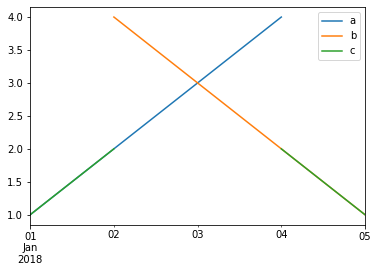

In [56]:
# Two ways of plotting
ts.plot()

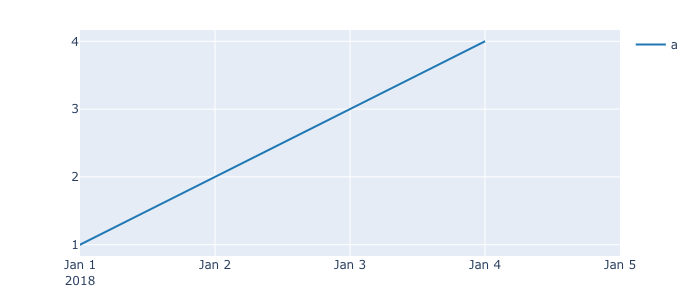

In [57]:
ts['a'].vbt.tseries.plot().show_png()

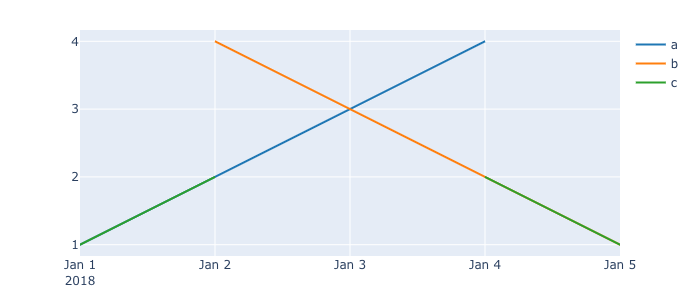

In [58]:
ts.vbt.tseries.plot().show_png()

## OHLCV

In [59]:
print(vbt.defaults.ohlcv['column_names'])

{'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}


In [60]:
try:
    ts.vbt.ohlcv.plot()
except Exception as e:
    print(e) # couldn't find default column names

'Open'


In [61]:
ohlcv_ts = pd.DataFrame({
    'open': [1, 2, 3], 
    'high': [1, 2, 3], 
    'low': [1, 2, 3], 
    'close': [1, 2, 3], 
    'volume': [1, 2, 3]
})

In [62]:
ohlcv_ts = pd.DataFrame(
    columns=['open', 'high', 'low', 'close', 'volume'],
    index=[datetime(2018, 1, 1) + timedelta(days=i) for i in range(10)]
)
ohlcv_ts['open'] = np.cumsum(np.random.uniform(-0.8, 1, size=(10,)))
ohlcv_ts['close'] = ohlcv_ts['open'] + np.random.uniform(-1, 1, size=(10,))
ohlcv_ts['high'] = ohlcv_ts['open'] + np.random.uniform(0, 1, size=(10,))
ohlcv_ts['low'] = ohlcv_ts['open'] - np.random.uniform(0, 1, size=(10,))
ohlcv_ts['volume'] = np.cumsum(np.random.uniform(-1, 1, size=(10,)))

print(ohlcv_ts)

                open      high       low     close    volume
2018-01-01  0.682521  0.939088  0.395273  0.426829 -0.777003
2018-01-02  1.147294  1.829564  0.702278  1.355300 -0.258893
2018-01-03  1.516433  2.398054  0.885094  1.876385 -0.355825
2018-01-04  2.464072  2.848961  2.385296  1.526629 -1.118541
2018-01-05  2.300956  2.545757  1.763400  3.249651 -1.227943
2018-01-06  2.143099  2.915750  1.913270  2.528735 -0.627281
2018-01-07  2.467950  2.624583  1.803368  1.607596 -1.367637
2018-01-08  3.441056  4.211892  3.386316  3.207001 -0.879139
2018-01-09  3.228444  4.073665  2.492668  3.869544 -0.157109
2018-01-10  3.945284  3.966644  3.548015  4.886817 -0.044770


In [63]:
try:
    ohlcv_ts.vbt.ohlcv.plot()
except Exception as e:
    print(e) # still couldn't find default column names

'Open'


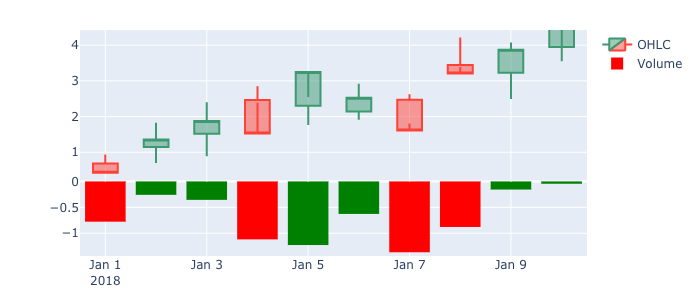

In [64]:
# Specify them manually
ohlcv_ts.vbt.ohlcv(column_names={
    'open': 'open', 
    'high': 'high', 
    'low': 'low', 
    'close': 'close', 
    'volume': 'volume'
}).plot().show_png()

In [65]:
# Or by changing the defaults
vbt.defaults.ohlcv['column_names'] = {
    'open': 'open', 
    'high': 'high', 
    'low': 'low', 
    'close': 'close', 
    'volume': 'volume'
}

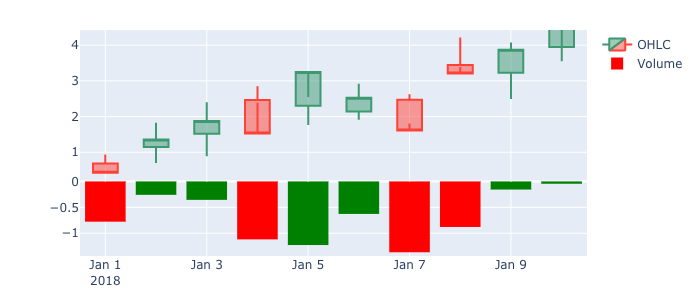

In [66]:
ohlcv_ts.vbt.ohlcv.plot().show_png()